<a target="_blank" href="https://colab.research.google.com/github/cerr/pyCERR-Notebooks/blob/main/image_filters_lung_ct.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# IBSI-2 compatible image texture using pyCERR


This notebook demonstrates how to apply IBSI-2 compatible image filters using pyCERR.

Supported filters include: *Mean*, *Sobel*, *Laplacian of Gaussian (LoG)*, *Laws'/Laws' Energy*, and *Gabor*.  
All filters are implemented as per the [IBSI2](https://theibsi.github.io/ibsi2/) standard, including support for 3D approximations and rotation invariance where defined.

## Install pyCERR (dev version)

In [1]:
%%capture
pip install git+https://github.com/cerr/pyCERR/

## Download settings

In [2]:
filterSettingsTarPath = '/content/convolution_filter_settings.gz'
! wget -O {filterSettingsTarPath} https://mskcc.box.com/shared/static/zt6qox6tnhov48ncl6txs4mlrd9rku8i.gz
! tar xf {filterSettingsTarPath}
! rm {filterSettingsTarPath}
! pip install jsbeautifier
settingsDir = '/content/convolutional_filter_settings'

--2024-01-22 17:33:46--  https://mskcc.box.com/shared/static/zt6qox6tnhov48ncl6txs4mlrd9rku8i.gz
Resolving mskcc.box.com (mskcc.box.com)... 74.112.186.144
Connecting to mskcc.box.com (mskcc.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/zt6qox6tnhov48ncl6txs4mlrd9rku8i.gz [following]
--2024-01-22 17:33:46--  https://mskcc.box.com/public/static/zt6qox6tnhov48ncl6txs4mlrd9rku8i.gz
Reusing existing connection to mskcc.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://mskcc.ent.box.com/public/static/zt6qox6tnhov48ncl6txs4mlrd9rku8i.gz [following]
--2024-01-22 17:33:46--  https://mskcc.ent.box.com/public/static/zt6qox6tnhov48ncl6txs4mlrd9rku8i.gz
Resolving mskcc.ent.box.com (mskcc.ent.box.com)... 74.112.186.144
Connecting to mskcc.ent.box.com (mskcc.ent.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://publ

## Read sample DICOM images

* The dataset used here, comprising a Lung CT scan with tumor segmentation, was made available by Lambin et al. via CancerData and is included with pyCERR.

* Selected filter parameters used in compatibilty tests with the IBSI-2 standard are used in this demonstration.

In [3]:
import os, numpy as np
from cerr import datasets, plan_container as pc

# Path to DICOM data
sampleDataPath = os.path.dirname(datasets.__file__)
sampleDataDir = os.path.join(sampleDataPath, 'radiomics_phantom_dicom', 'PAT1')

# Import contents to planC
planC = pc.load_dcm_dir(sampleDataDir)

('PAT1', 'PAT1', '1.3.6.1.4.1.9590.100.1.2.96328687310426543129572151154132284399', '1.3.6.1.4.1.9590.100.1.2.258301620411152643708006163321128526885', 'RTSTRUCT', 'RTSTRUCT', 'RTSTRUCT', 'RTSTRUCT', 'RTSTRUCT', 'RTSTRUCT', 'RTSTRUCT')
('PAT1', 'PAT1', '1.3.6.1.4.1.9590.100.1.2.96328687310426543129572151154132284399', '1.3.6.1.4.1.9590.100.1.2.296658988911737913102339329841519593982', 'CT', 'CT', 'CT', 'CT', 'CT', 'CT', 'CT')


## Apply IBSI2 filters

*Note*:
* Sample filter settings can be downloaded from [https://github.com/cerr/pyCERR-Notebooks](https://github.com/cerr/pyCERR-Notebooks/settings/). The `settingsDir` variable below should point to directory containing settings files.
* The examples below use the *Napari* package for visualization. *Napari* requires a display for rendering graphics and does not support interactive visualization on a remote server (e.g. Google Colab).

### Review filter settings

In [4]:
import json, jsbeautifier
from cerr.radiomics import textureUtils

options = jsbeautifier.default_options()
options.indent_size = 4

# Path to JSON settings file with filter parameters
settingsFile = os.path.join(settingsDir, 'mean_filter.json')  #Replace with Path to sample mean filter settings file
paramS, __ = textureUtils.loadSettingsFromFile(settingsFile)

# Display settings
print(jsbeautifier.beautify(json.dumps(paramS), options))

# Compute filter response
scanNum = 0
strNum = 0
planC = textureUtils.generateTextureMapFromPlanC(planC, scanNum, strNum, settingsFile)
filtIdx = len(planC.scan)-1         # Index of filtered scan


{
    "structures": ["GTV"],
    "imageType": {
        "Mean": {
            "KernelSize": [5, 5, 5]
        }
    },
    "settings": {
        "padding": {
            "method": "expand",
            "size": [2, 2, 2]
        }
    }
}


### Copy Structure from CT to filtered image

In [5]:
import cerr.dataclasses.structure as cerrStr
structNum = 0
filteredScanNum = 1
planC = cerrStr.copyToScan(0, 1, planC)

## Capture screenshot

In [6]:
!export NAPARI_APPLICATION_IPY_INTERACTIVE=0
!export QT_DEBUG_PLUGINS=1 > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install libqt5x11extras5-dev > /dev/null 2>&1
!apt-get install x11-utils > /dev/null 2>&1
!pip install pyglet > /dev/null 2>&1
!apt-get install -y xvfb > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
from pyvirtualdisplay import Display
virtualDisplay = Display(backend="xvfb", size=(600, 600))
virtualDisplay.start()

saved to filtered_img.png


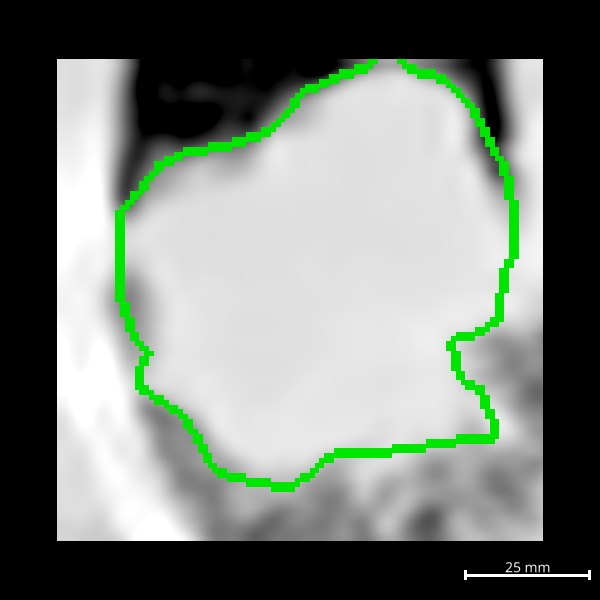

In [7]:
from IPython.display import Image, display
from cerr import plan_container as pc
import cerr.contour.rasterseg as rs
from cerr import viewer as vwr
from skimage.io import imsave, imshow
import numpy as np
import os

capture_fname = 'filtered_img.png'
dispScanNum = [filtIdx]
dispStrNum = [len(planC.structure)-1]
dispDoseNum = []
displayMode = '2d'
viewer, scan_layer, dose_layer, struct_layer = \
vwr.show_scan_struct_dose(dispScanNum, dispStrNum, dispDoseNum, planC, displayMode)
scan_layer[0].opacity = 1
scan_layer[0].contrast_limits_range = [-800, 200]
scan_layer[0].contrast_limits = [-800, 200]
scan_layer[0].gamma = 0.7

screenshot = viewer.screenshot(size =(600, 600))
viewer.close()
imsave(capture_fname, screenshot)
print('saved to '+ capture_fname)
display(Image(filename=capture_fname, retina=False, width=200, embed=True))

In [8]:
scan3M = planC.scan[-1].getScanArray()
print(planC.scan[-1].scanInfo[0].imageType)
print(scan3M.min())
print(scan3M.max())

Mean
-962.592
361.51199999999983
